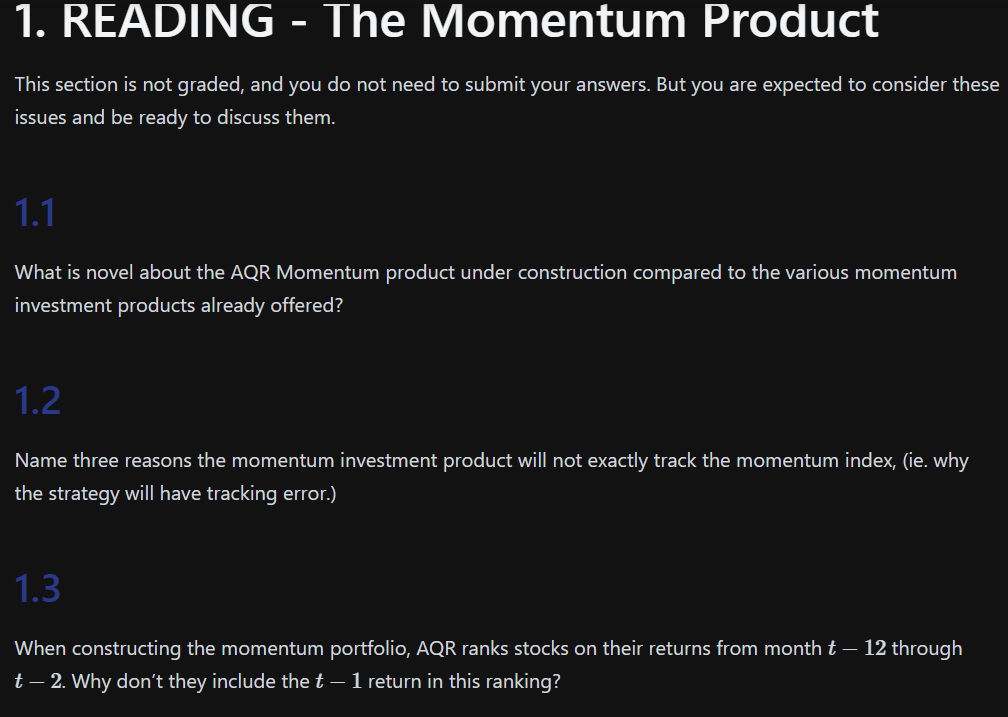

## 1.1
AQR Momentum product is designed to be a sold by a mutual fund, while the existing momentum products were offered by hedge funds where there is not restriction to go short on a stock. Offering the product as a mutual fund meant that AQR could only go long on the top performing stocks (winners) and not being able to double their strategy alpha (expected alpha) by shorting the low performing stocks (losers)

## 1.2
1. Transaction costs associated with trading the ever changing list of winners will produce a deviation from the index returns
2. While the index assumes that buying and selling the stocks occur without slippage, in the real world, there is going to slippage which contributes to tracking error
3. Mutual fund fees and tax implications also contribute to tracking error

## 1.3
Because of empirical evidence that the t-1 returns of stocks showing that the winners here are going to be out of the winner band and losers are going to be out of the loser band. This shows a reversal trend than the momentum trend, so it was decided to take t-1 out of the calculation.

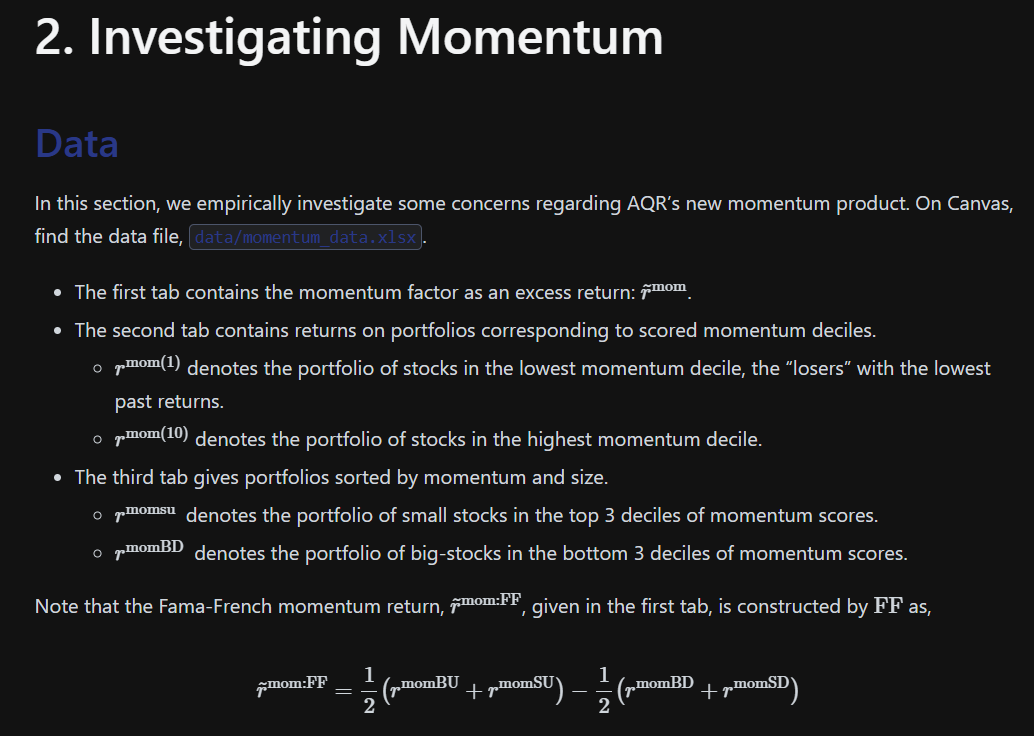
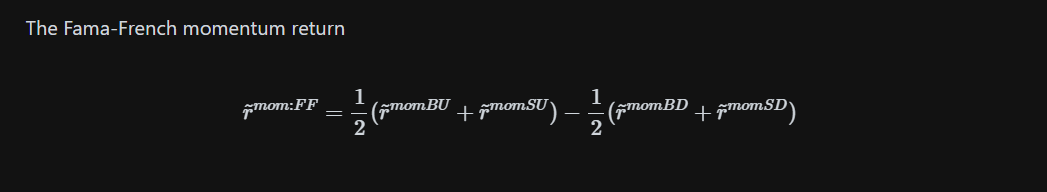

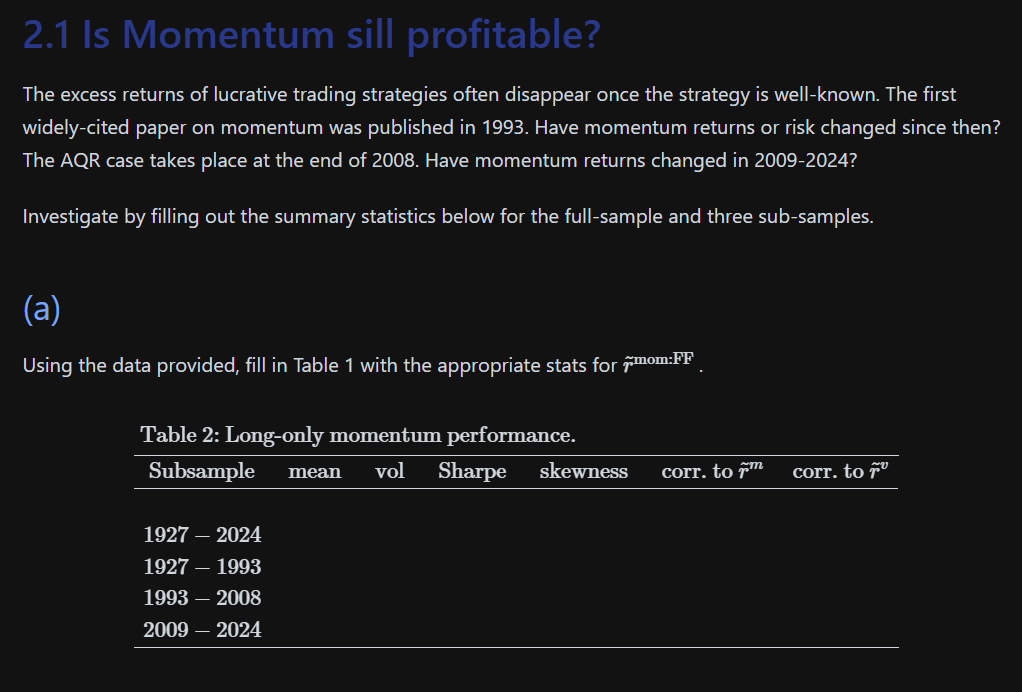

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# create time periods for 1927-2024, 1927-1993, 1993-2008, 2009-2024
periods = [
    (pd.Timestamp('1927-01-01'), pd.Timestamp('2024-12-31')),
    (pd.Timestamp('1927-01-01'), pd.Timestamp('1993-12-31')),
    (pd.Timestamp('1993-01-01'), pd.Timestamp('2008-12-31')),
    (pd.Timestamp('2009-01-01'), pd.Timestamp('2024-12-31'))
]

factor_rets = pd.read_excel('data/momentum_data.xlsx',sheet_name='factors (excess returns)', parse_dates=['Date'], index_col='Date') 
value_rets = factor_rets['HML']
mkt_rets = factor_rets['MKT']

momentum_rets = pd.read_excel('data/momentum_data.xlsx', sheet_name='momentum (excess returns)', parse_dates=['Date'], index_col='Date')
cols = ['Subsample', 'mean', 'vol', 'Sharpe', 'skewness', 'corr. to r(mkt)', 'corr. to r(hml)']
statistics = {}
FREQ = 12
for period in periods:
    start, end = period
    mask = (momentum_rets.index >= start) & (momentum_rets.index <= end)
    subsample = momentum_rets.loc[mask, 'UMD']
    mean = subsample.mean() * FREQ
    vol = subsample.std() * np.sqrt(FREQ)
    sharpe = mean / vol if vol != 0 else np.nan
    skewness = subsample.skew()
    corr_mkt = subsample.corr(mkt_rets.loc[mask])
    corr_hml = subsample.corr(value_rets.loc[mask])
    
    label = f"{start.year}-{end.year}"
    statistics[label] = [mean, vol, sharpe, skewness, corr_mkt, corr_hml]

stats_df = pd.DataFrame.from_dict(statistics, orient='index', columns=cols[1:])
display(stats_df.round(4))
    

,mean,vol,Sharpe,skewness,corr. to r(mkt),corr. to r(hml)
1927-2024,0.0739,0.1627,0.4540,-3.0673,-0.3492,-0.4098
1927-1993,0.0881,0.1605,0.5491,-3.9110,-0.3675,-0.5010
1993-2008,0.1094,0.1717,0.6371,-0.6306,-0.2310,-0.0920
2009-2024,-0.0129,0.1580,-0.0816,-2.6916,-0.3702,-0.3190


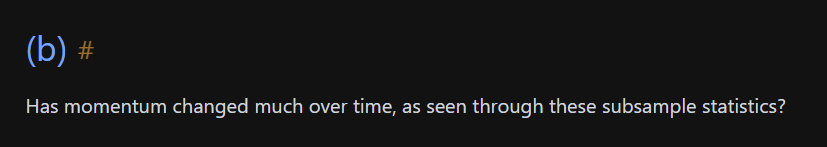

Yes, momentum's performance has decreased when cmopared to the 1993-2008 period. It can be seen from the negative mean and sharpe values. It can be a good diversifying factor nonetheless as it has been showing negative correlation with MKT, HML (value) factors consistently.

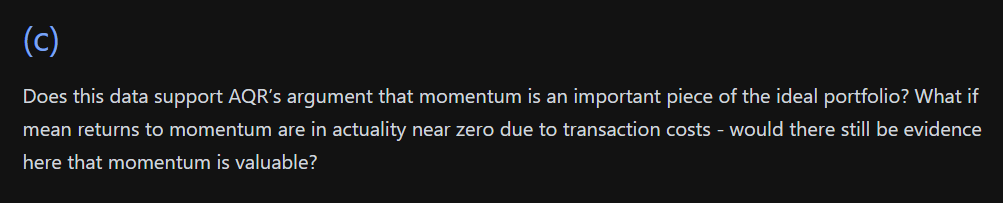


For the overall in-sample analysis, momentum has positive excess returns and it has negative correlation with the other factors (MKT, HML). It adds value to the portfolio by having positive excess returns and negative correlations to other factors. 

Yes, it still can be a valuable factor given it's negative correlation.


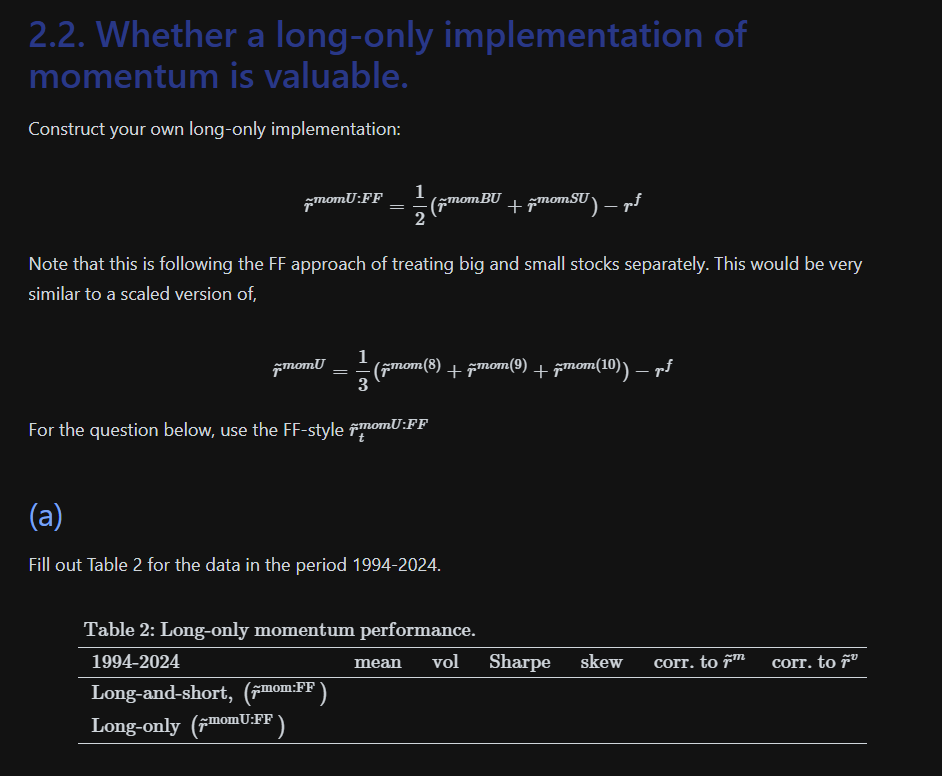

,mean,vol,Sharpe,skewness,corr. to r(mkt),corr. to r(hml)
SMALL HiPRIOR,0.1308,0.2135,0.6127,-0.2012,0.8293,-0.0707
BIG HiPRIOR,0.1014,0.1587,0.6390,-0.4742,0.9117,-0.1657
long-only-momentum,0.1161,0.1780,0.6524,-0.4420,0.9040,-0.1163


,mean,vol,Sharpe,skewness,corr. to r(mkt),corr. to r(hml)
SMALL LoPRIOR,0.0694,0.2764,0.2511,0.5264,0.8303,0.0306
BIG LoPRIOR,0.0768,0.2305,0.3329,0.1455,0.8504,0.0890
short-only-momentum,0.0731,0.2458,0.2974,0.3761,0.8659,0.0590


,mean,vol,Sharpe,skewness,corr. to r(mkt),corr. to r(hml)
long-short-momentum,0.043,0.1672,0.2573,-1.4612,-0.3105,-0.2104


<Axes: title={'center': 'Log Cumulative Returns: Long-Only vs Short-Only Momentum'}, xlabel='Date'>

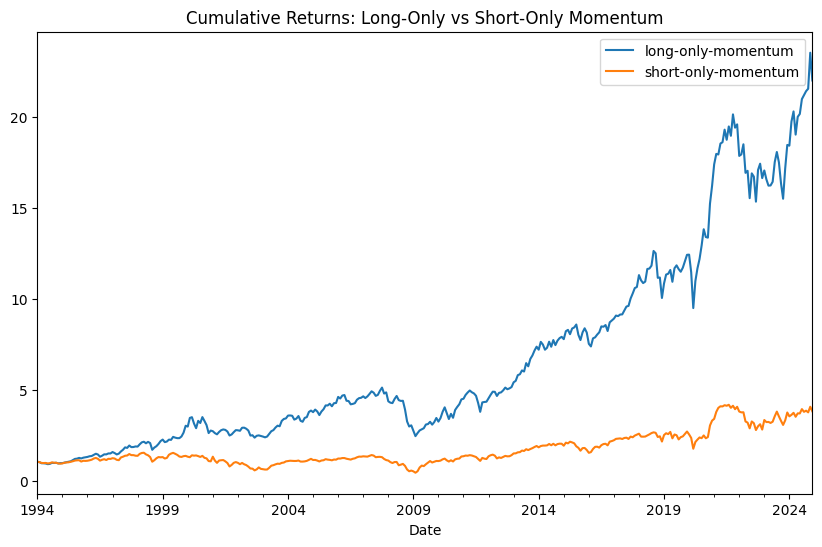

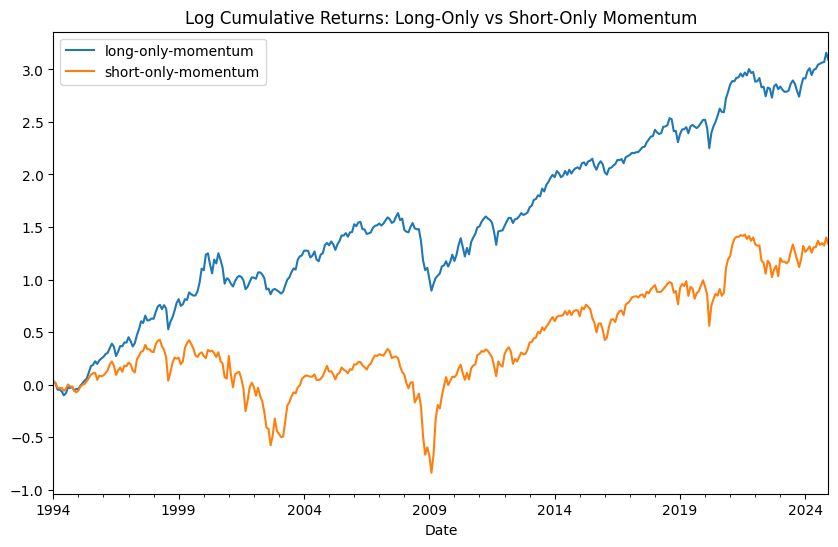

In [44]:
period = [(pd.Timestamp('1994-01-01'), pd.Timestamp('2024-12-31'))]

# construct long-only and short-only momentum returns
rf_rets = pd.read_excel('data/momentum_data.xlsx', sheet_name='risk-free rate', parse_dates=['Date'], index_col='Date')['RF']

long_only_mom = ['SMALL HiPRIOR', 'BIG HiPRIOR']
size_data = pd.read_excel('data/momentum_data.xlsx', sheet_name='size_sorts (total returns)', parse_dates=['Date'], index_col='Date')
size_data_excess_rets = size_data.subtract(rf_rets, axis=0)
mask = (size_data_excess_rets.index >= period[0][0]) & (size_data_excess_rets.index <= period[0][1])
long_only_rets = size_data_excess_rets.loc[mask, long_only_mom] 

# Sum across weighted columns to get a combined time series (one value per row/date)
weights = pd.Series({'SMALL HiPRIOR': 0.5, 'BIG HiPRIOR': 0.5})
overall_long_only = long_only_rets.mul(weights, axis=1).sum(axis=1)

# Convert the Series to a DataFrame and give the column the requested name
overall_long_only = overall_long_only.to_frame(name='long-only-momentum')

long_only_rets['long-only-momentum'] = overall_long_only['long-only-momentum']
stats_df2 = pd.DataFrame(columns=['mean', 'vol', 'Sharpe', 'skewness', 'corr. to r(mkt)', 'corr. to r(hml)'])
for col in long_only_rets.columns:
    mean = long_only_rets[col].mean() * FREQ
    vol = long_only_rets[col].std() * np.sqrt(FREQ)
    sharpe = mean / vol if vol != 0 else np.nan
    skewness = long_only_rets[col].skew()
    corr_mkt = long_only_rets[col].corr(mkt_rets)
    corr_hml = long_only_rets[col].corr(value_rets)
    
    stats_df2.loc[col] = [mean, vol, sharpe, skewness, corr_mkt, corr_hml]

display(stats_df2.round(4))

# do the same analysis for short-only momentum
short_only_mom = ['SMALL LoPRIOR', 'BIG LoPRIOR']
short_only_rets = size_data_excess_rets.loc[mask, short_only_mom]

# Sum across weighted columns to get a combined time series (one value per row/date)
weights = pd.Series({'SMALL LoPRIOR': 0.5, 'BIG LoPRIOR': 0.5})
overall_short_only = short_only_rets.mul(weights, axis=1).sum(axis=1)
overall_short_only = overall_short_only.to_frame(name='short-only-momentum')
short_only_rets['short-only-momentum'] = overall_short_only['short-only-momentum']
stats_df3 = pd.DataFrame(columns=['mean', 'vol', 'Sharpe', 'skewness', 'corr. to r(mkt)', 'corr. to r(hml)'])
for col in short_only_rets.columns:
    mean = short_only_rets[col].mean() * FREQ
    vol = short_only_rets[col].std() * np.sqrt(FREQ)
    sharpe = mean / vol if vol != 0 else np.nan
    skewness = short_only_rets[col].skew()
    corr_mkt = short_only_rets[col].corr(mkt_rets)
    corr_hml = short_only_rets[col].corr(value_rets)
    
    stats_df3.loc[col] = [mean, vol, sharpe, skewness, corr_mkt, corr_hml]

display(stats_df3.round(4))

# do the above analysis for long-short momentum for the given sample period

long_short_rets = long_only_rets['long-only-momentum'] - short_only_rets['short-only-momentum']
stats_df4 = pd.DataFrame(columns=['mean', 'vol', 'Sharpe', 'skewness', 'corr. to r(mkt)', 'corr. to r(hml)'])
mean = long_short_rets.mean() * FREQ
vol = long_short_rets.std() * np.sqrt(FREQ)
sharpe = mean / vol if vol != 0 else np.nan
skewness = long_short_rets.skew()
corr_mkt = long_short_rets.corr(mkt_rets)
corr_hml = long_short_rets.corr(value_rets)

stats_df4.loc['long-short-momentum'] = [mean, vol, sharpe, skewness, corr_mkt, corr_hml]

display(stats_df4.round(4))

cum_rets1 = (pd.DataFrame([
    long_only_rets['long-only-momentum'],
    short_only_rets['short-only-momentum']
]).T+1).cumprod()

cum_rets1.plot(kind='line', figsize=(10,6), title='Cumulative Returns: Long-Only vs Short-Only Momentum')
log_cum_rets1 = np.log(cum_rets1)
log_cum_rets1.plot(kind='line', figsize=(10,6), title = 'Log Cumulative Returns: Long-Only vs Short-Only Momentum')

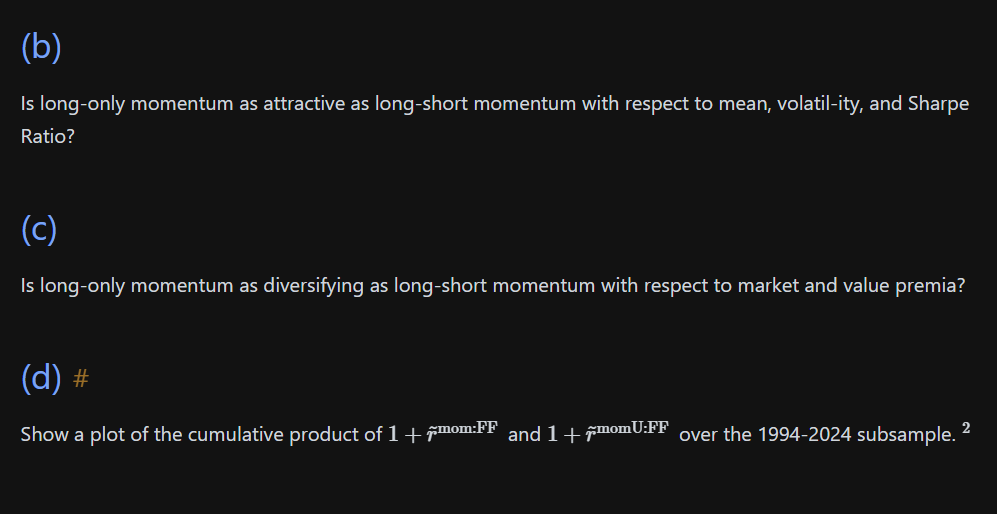

## 2.2.b
Yes, long only momentum is attrative ctive in terms of mean, svharpe ratio fo rr the overall sample period.

## 2.2.c
NO, long only momentum has high correlation with MKT factor(0.90) and negative correlation (-0.1) with value factor, where as long-short factor has negative correlations with both MKT, HMKL factors

## 2.2.d
Plotted the returns in the above charts

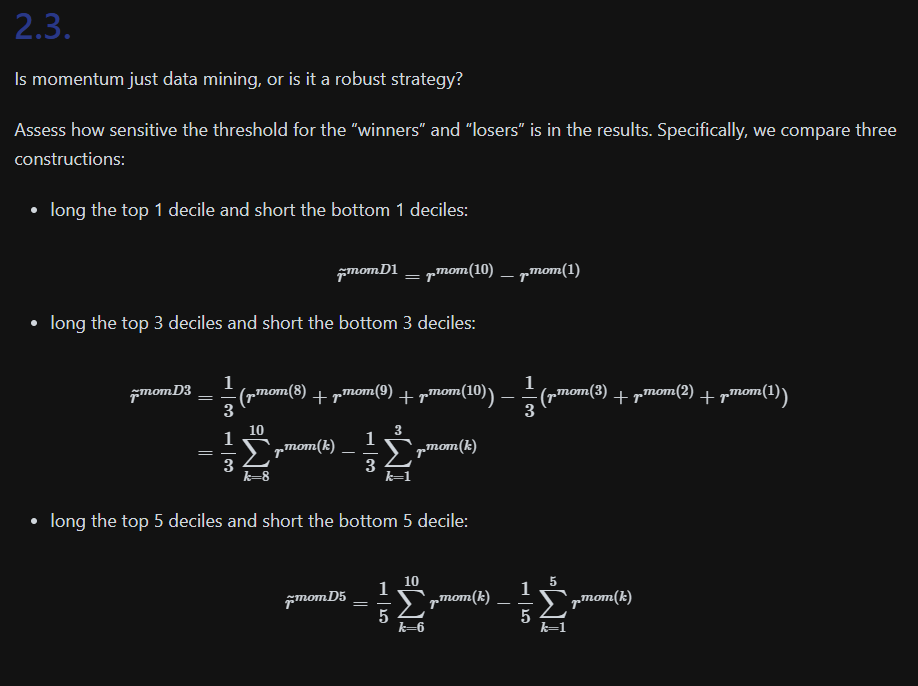

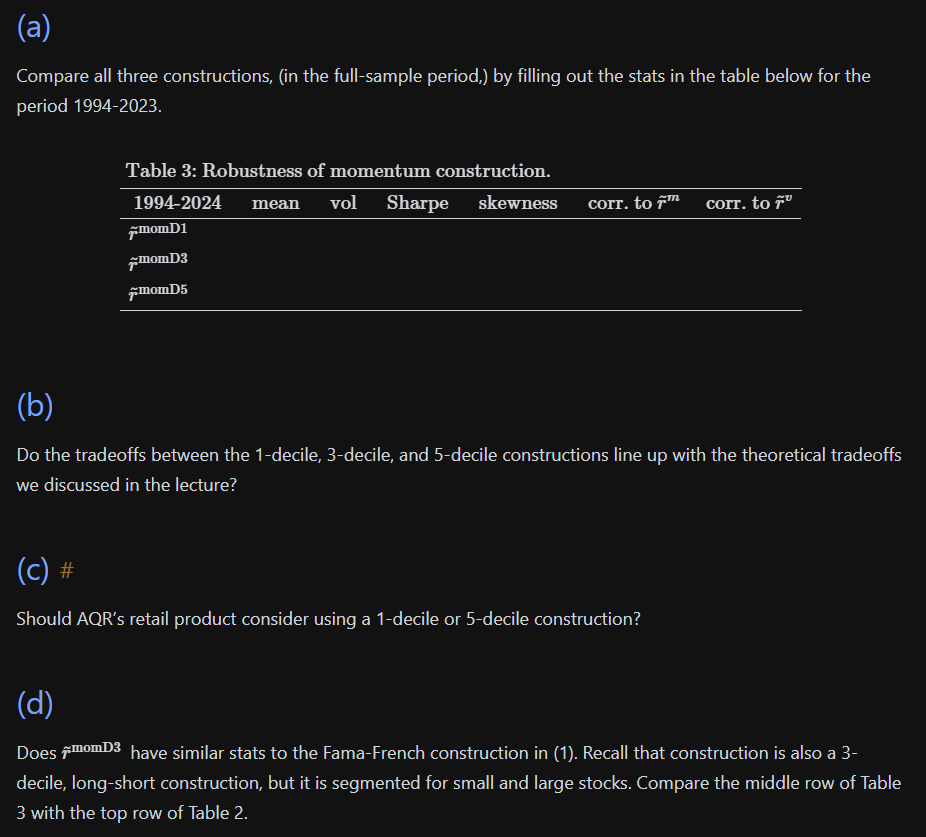

In [51]:
deciles_data = pd.read_excel('data/momentum_data.xlsx', sheet_name='deciles (total returns)', parse_dates=['Date'], index_col='Date')
deciles_excess_rets = deciles_data.subtract(rf_rets, axis=0)

mask = (deciles_excess_rets.index >= period[0][0]) & (deciles_excess_rets.index <= period[0][1])

deciles_rets = deciles_excess_rets.loc[mask]

# construct D1, D3, D5 momentum portfolios
cols = deciles_rets.columns
decile_portfolios = {
    'Mom D1': -1*deciles_rets[cols[0:1]].sum(axis=1) + deciles_rets[cols[-1:]].sum(axis=1),
    # 'Mom D2': (-1*deciles_rets[cols[0:2]].sum(axis=1) + deciles_rets[cols[-2:]].sum(axis=1))/2,
    'Mom D3': (-1*deciles_rets[cols[0:3]].sum(axis=1) + deciles_rets[cols[-3:]].sum(axis=1))/3,
    'Mom D5': (-1*deciles_rets[cols[0:5]].sum(axis=1) + deciles_rets[cols[-5:]].sum(axis=1))/5,
}

stats_df5 = pd.DataFrame(columns=['mean', 'vol', 'Sharpe', 'skewness', 'corr. to r(mkt)', 'corr. to r(hml)'])
for label, returns in decile_portfolios.items():
    mean = returns.mean() * FREQ
    vol = returns.std() * np.sqrt(FREQ)
    sharpe = mean / vol if vol != 0 else np.nan
    skewness = returns.skew()
    corr_mkt = returns.corr(mkt_rets.loc[mask])
    corr_hml = returns.corr(value_rets.loc[mask])
    
    stats_df5.loc[label] = [mean, vol, sharpe, skewness, corr_mkt, corr_hml]

display(stats_df5.round(4))

,mean,vol,Sharpe,skewness,corr. to r(mkt),corr. to r(hml)
Mom D1,0.0810,0.2996,0.2703,-1.3012,-0.3242,-0.2375
Mom D3,0.0297,0.1937,0.1535,-1.3411,-0.3632,-0.2121
Mom D5,0.0173,0.1343,0.1285,-1.4215,-0.3544,-0.2087


## 2.3.b
Yes the long-short portfolio that takes the most extremes has higher return but it also has a higher volatility. We could expect the volatility to act differently, as taking on more winners (or losers) could diversify and hence lower volatility.

## 2.3.c
decile1 construction should be preferred over decile5 given the higher mean and sharpe of the decile1 momentum portofolio. It is worth to note that the correlation to MKT, HML remains amlost the same with the two construction methods, indicating that decile1 construction is better than the decile5 construction.

## 2.3.d
No, the decile3 and mom-FF have different stats. The differences are expected as the mom-FF construction methodology uses bivariate segregation of asset returns, i.e., the segregation is done size and t-12 to t-2 returns while the decile3 is segregates the assets based on their t-12 to t-2 returns.

The correlations with MKT, HML remain the same with little differences while the vol mean return and sharpe are higher for mom-FF methodology. 


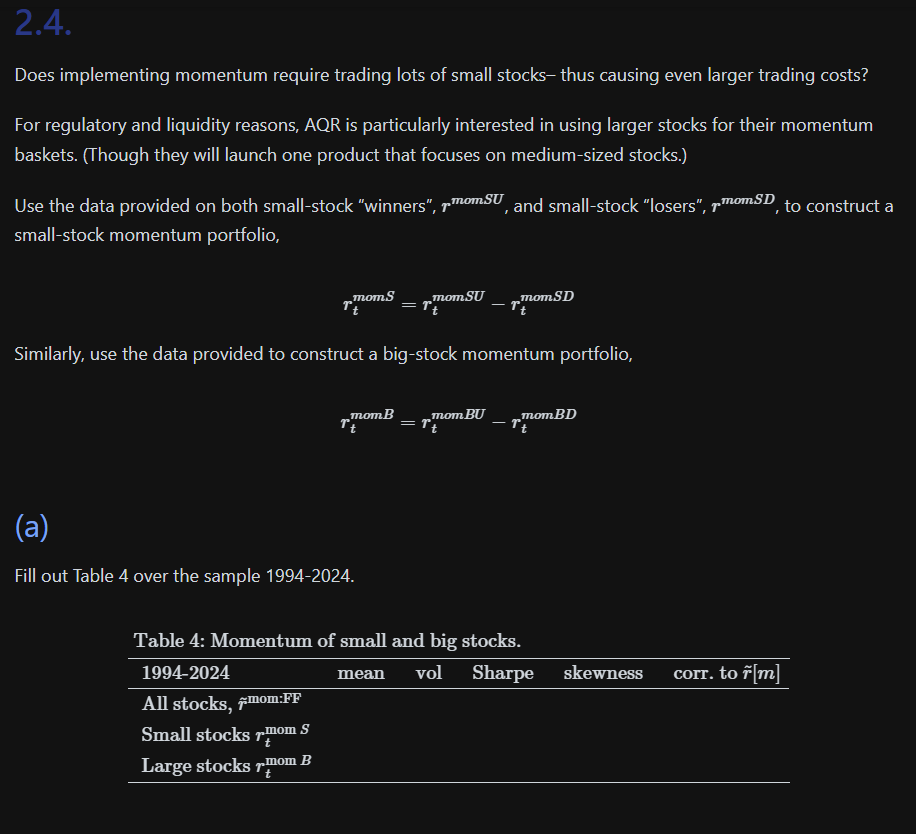

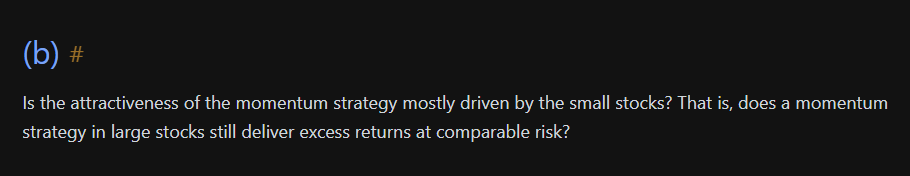

In [58]:
small_stocks_mom = long_only_rets['SMALL HiPRIOR'] - short_only_rets['SMALL LoPRIOR']
Large_stocks_mom = long_only_rets['BIG HiPRIOR'] - short_only_rets['BIG LoPRIOR']
stats_df6 = pd.DataFrame(columns=['mean', 'vol', 'Sharpe', 'skewness', 'corr. to r(mkt)'])

# stats_df4 -> has the data for long-short momentum all
for label, returns in {'Small Stocks Mom': small_stocks_mom, 'Large Stocks Mom': Large_stocks_mom}.items():
    mean = returns.mean() * FREQ
    vol = returns.std() * np.sqrt(FREQ)
    sharpe = mean / vol if vol != 0 else np.nan
    skewness = returns.skew()
    corr_mkt = returns.corr(mkt_rets.loc[mask])
    
    
    stats_df6.loc[label] = [mean, vol, sharpe, skewness, corr_mkt]

# reindex stats_df4 to have 'All Stocks Mom' as index
stats_df4.index = ['All Stocks Mom']
consolidated_stats = pd.concat([stats_df4[stats_df6.columns], stats_df6])

display(consolidated_stats.round(4))

,mean,vol,Sharpe,skewness,corr. to r(mkt)
All Stocks Mom,0.0430,0.1672,0.2573,-1.4612,-0.3105
Small Stocks Mom,0.0614,0.1691,0.3631,-1.8042,-0.3102
Large Stocks Mom,0.0246,0.1823,0.1351,-0.8745,-0.2819


## 2.4.b
Yes, with the data in the above table, it looks like the higher risk adjusted returns for the All stocks momentum strategy is contributed by the small stocks momentum.
No, the momentum strategy in large stocks doesn't give the same risk adjusted returns as the small stocks momentum strategy. This can be seen by the lower sharpe of large stocks compared to small stocks momentum.

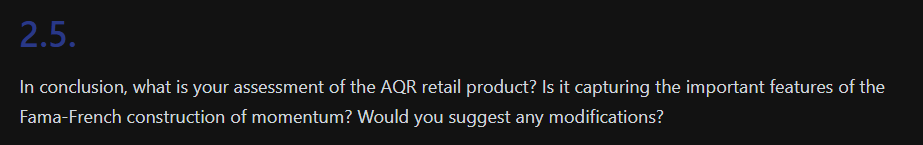

No, the AQR retail product is not capturing the important features. In the mom-FF methodology, the factor has negative correlation with the MKT, HML factors, whereas the AQR one has high positive correlation with MKT factor and not significant negataive correlation with the HML factor. 

I would suggest AQR to replicate the short position in stocks using derivatives.